Loading and processing data

(1000, 200, 200)
(1000, 10)


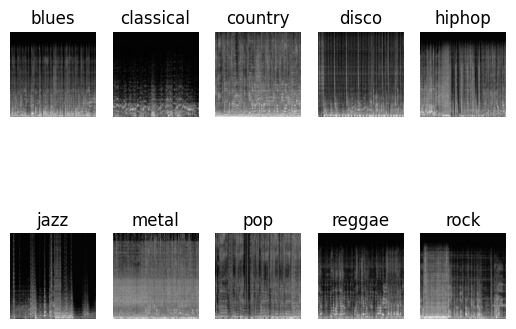

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from Help import *
import random
import pandas as pd

images = np.load("../data/processed/images.npy")
labels = np.load("../data/processed/labels.npy")
print(images.shape)
print(labels.shape)
input_shape = images.shape[1:]
fig, axs = plt.subplots(2, 5)
df = pd.read_csv("../data/Data/features_30_sec.csv", usecols=["label"])
label_texts = (sorted(df["label"].unique()))
axs = [ax for row in axs for ax in row]
for i in range(10):
    ax = axs[i]
    ax.axis("off")
    ax.set_title(label_texts[i])
    
    ax.imshow(images[100*i+0], cmap="gray")

plt.imshow(images[260], cmap="gray")
plt.show()

5
194
286
385
410
582
620
711
897
982


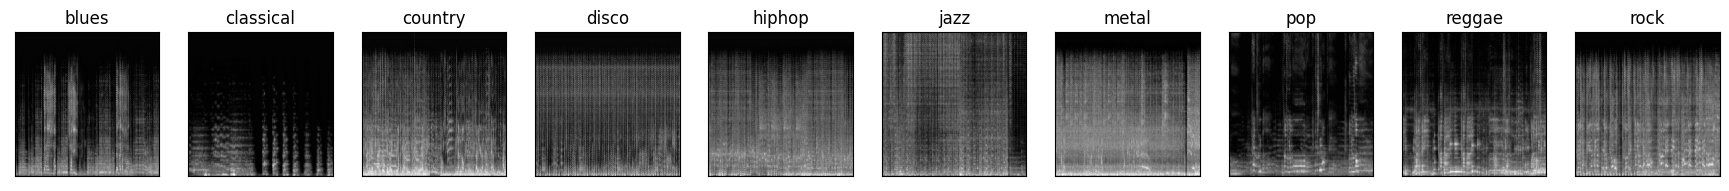

In [46]:
ShowImageFromEachClass(images)

In [47]:
from sklearn.model_selection import train_test_split

# Splitting data into train and test set
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=1.0/3)
print("Train set length:" + str(len(x_train)))
print("Validation set length:" + str(len(x_valid)))
print("Test set length:" + str(len(x_test)))


Train set length:700
Validation set length:200
Test set length:100


Describing the model

In [49]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation

num_classes = 10
inputs = Input(shape=(input_shape + (1,))) # Nicer way to add this 1 as a dimension?

# lamda is the weight of the L2 penalty term
lamda = 0.25
L2_regularizer = keras.regularizers.l2(lamda)
initializer = tf.keras.initializers.HeNormal()


# ********************************************* Model ********************************************
# Encoder (convolutional base)
x = BatchNormalization()(inputs)
x = Conv2D(8, kernel_size=(5, 5), kernel_regularizer=L2_regularizer,  kernel_initializer=initializer)(inputs)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(16, kernel_size=(5, 5),kernel_regularizer=L2_regularizer)(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(8, kernel_size=(5, 5),kernel_regularizer=L2_regularizer)(x)
x = Activation('relu')(x)
x = MaxPooling2D((4, 4))(x)
x = BatchNormalization()(x)
# x = Conv2D(32, kernel_size=(5, 5),kernel_regularizer=L2_regularizer)(x)
# x = Activation('relu')(x)
# x = BatchNormalization()(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(32,kernel_regularizer=L2_regularizer)(encoded)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(32,kernel_regularizer=L2_regularizer)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)

predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()
# ********************************************* Model ********************************************

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 196, 196, 8)       208       
                                                                 
 activation (Activation)     (None, 196, 196, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 8)        0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 98, 98, 8)        32        
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 16)        3216  

In [50]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.0001, nesterov=True),
              metrics=['accuracy'])

In [38]:
history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=True)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
25/25 [==============================] - 16s 575ms/step - loss: 28.3238 - accuracy: 0.1925 - val_loss: 22.5138 - val_accuracy: 0.1300
Epoch 2/10
25/25 [==============================] - 14s 548ms/step - loss: 17.8197 - accuracy: 0.2862 - val_loss: 14.3120 - val_accuracy: 0.1700
Epoch 3/10
25/25 [==============================] - 14s 562ms/step - loss: 11.5529 - accuracy: 0.3175 - val_loss: 9.5361 - val_accuracy: 0.2150
Epoch 4/10
25/25 [==============================] - 15s 583ms/step - loss: 7.6646 - accuracy: 0.3500 - val_loss: 6.8065 - val_accuracy: 0.0950
Epoch 5/10
25/25 [==============================] - 15s 593ms/step - loss: 5.3969 - accuracy: 0.3650 - val_loss: 5.2459 - val_accuracy: 0.0750
Epoch 6/10
25/25 [==============================] - 15s 592ms/step - loss: 4.1637 - accuracy: 0.3512 - val_loss: 4.0788 - val_accuracy: 0.1300
Epoch 7/10
25/25 [==============================] - 15s 622ms/step - loss: 3.3031 - accuracy: 0.3812 - val_loss: 3.6678 - val_accuracy: 0

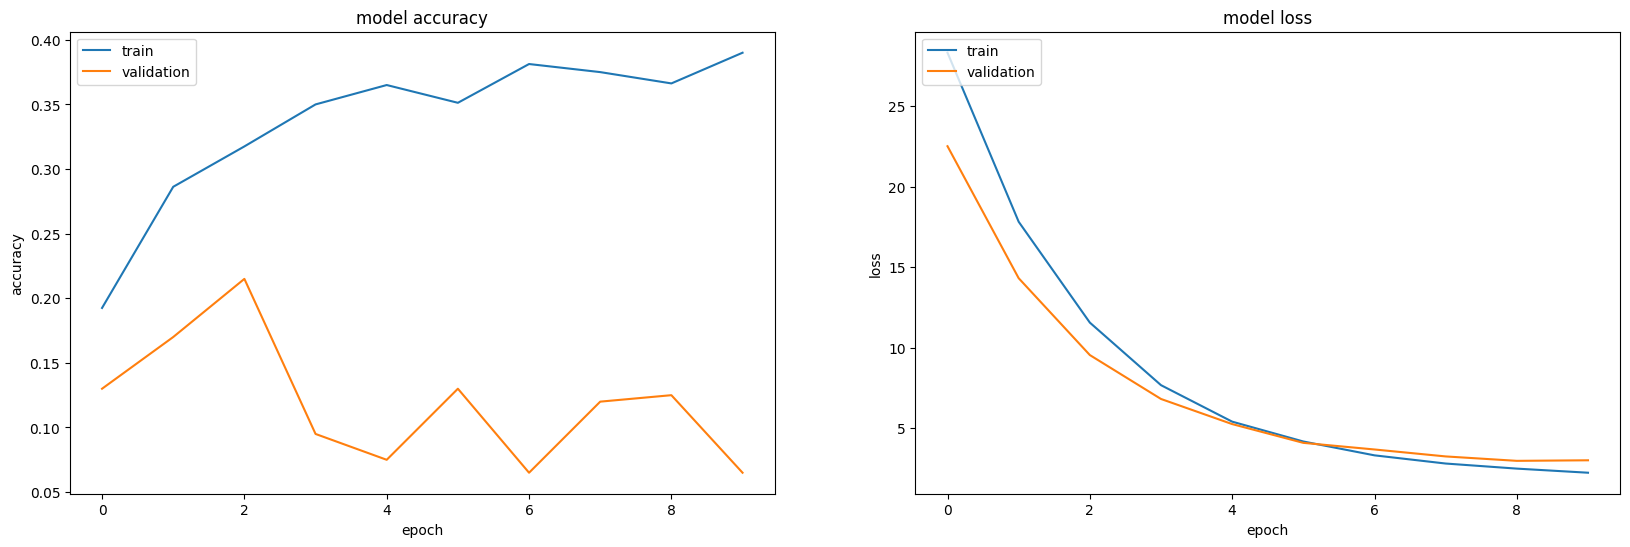

In [39]:
def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

show_history(history)

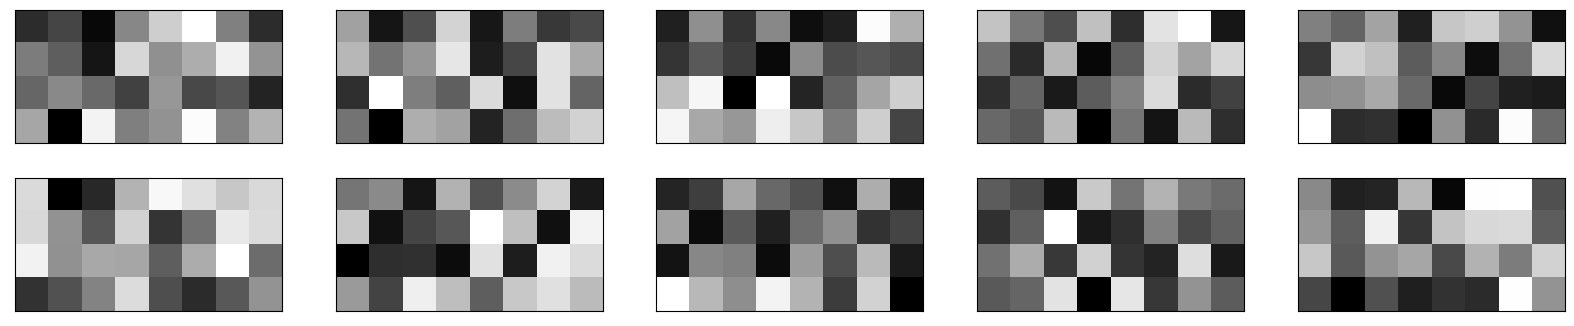

In [40]:
# Displaying the last weights
W = np.asarray(model.layers[-1].get_weights()[0])

W = W.reshape((4,8,10))
plt.figure(figsize=(20,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

In [41]:
predictions = model.predict(x_test)


def top1_error(preds,labels):
  return np.mean(np.argmax(preds,axis=1) != np.argmax(labels,axis=1))

print("Top-1 error is: " + str(top1_error(predictions,y_test[:len(predictions)])))


def top5_error(preds,labels):
  argsorted = np.argsort(np.argsort(preds,axis=1),axis=1)
  arg_of_1 = np.asarray(np.where(labels == 1))
  positions = argsorted[arg_of_1[0],arg_of_1[1]]
  num_of_wrong = np.count_nonzero(positions <= 4)
  return num_of_wrong / len(preds)

def top5_error_for_psychopaths(preds,labels):
  return np.count_nonzero(np.argsort(np.argsort(preds,axis=1),axis=1)[np.asarray(np.where(labels))[0],np.asarray(np.where(labels))[1]] <= 4) / len(preds)


print("Top-5 error is: " + str(top5_error_for_psychopaths(predictions,y_test[:len(predictions)])))

7/7 [==============================] - 1s 105ms/step
Top-1 error is: 0.935
Top-5 error is: 0.535


In [43]:
print(len(predictions))
print(len(y_test))
print(predictions[20:26])
print(y_test[20:26])


200
200
[[0.192492   0.24168552 0.08016586 0.03119889 0.04628628 0.1905253
  0.0372434  0.07804372 0.0686992  0.03365984]
 [0.19597615 0.31630072 0.06132608 0.01862496 0.02886461 0.2131114
  0.03098312 0.06531885 0.04738812 0.02210606]
 [0.18135117 0.19749427 0.09541479 0.04256188 0.06241307 0.16774495
  0.04179629 0.08258155 0.0856518  0.04299015]
 [0.19362363 0.29334235 0.06789293 0.02220694 0.0339436  0.2069933
  0.03335563 0.06881056 0.05415975 0.02567126]
 [0.1929902  0.27197033 0.07301693 0.02516898 0.03810646 0.20411892
  0.0346779  0.07210451 0.05943086 0.02841485]
 [0.18709835 0.2289777  0.08420306 0.03424373 0.05026166 0.18455124
  0.03815984 0.08201424 0.07363575 0.0368544 ]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [90]:
def ShowWeightStats(model):
    for layer in model.layers:
        print(layer)
        print(type(layer))
        if len(layer.get_weights()) != 0 and type(layer) != keras.layers.normalization.batch_normalization.BatchNormalization:
            w = np.asarray(layer.get_weights()[0]).flatten()
            b = layer.get_weights()[1]
            plt.hist(w)
            plt.show()

ShowWeightStats(model)




<class 'keras.engine.input_layer.InputLayer'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>


AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'normalization'